# Imports

In [22]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

### Import utility functions

In [23]:
from helper_data import get_dataloaders_celeba
from helper_data import compute_average_faces
from helper_plotting import plot_modified_faces
from helper_data import UnNormalize
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_accuracy, plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [24]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 3

"""Targets are 40-dim vectors representing
    00 - 5_o_Clock_Shadow
    01 - Arched_Eyebrows
    02 - Attractive
    03 - Bags_Under_Eyes
    04 - Bald
    05 - Bangs
    06 - Big_Lips
    07 - Big_Nose
    08 - Black_Hair
    09 - Blond_Hair
    10 - Blurry
    11 - Brown_Hair
    12 - Bushy_Eyebrows
    13 - Chubby
    14 - Double_Chin
    15 - Eyeglasses
    16 - Goatee
    17 - Gray_Hair
    18 - Heavy_Makeup
    19 - High_Cheekbones
    20 - Male
    21 - Mouth_Slightly_Open
    22 - Mustache
    23 - Narrow_Eyes
    24 - No_Beard
    25 - Oval_Face
    26 - Pale_Skin
    27 - Pointy_Nose
    28 - Receding_Hairline
    29 - Rosy_Cheeks
    30 - Sideburns
    31 - Smiling
    32 - Straight_Hair
    33 - Wavy_Hair
    34 - Wearing_Earrings
    35 - Wearing_Hat
    36 - Wearing_Lipstick
    37 - Wearing_Necklace
    38 - Wearing_Necktie
    39 - Young
    """

Device: cpu


'Targets are 40-dim vectors representing\n    00 - 5_o_Clock_Shadow\n    01 - Arched_Eyebrows\n    02 - Attractive\n    03 - Bags_Under_Eyes\n    04 - Bald\n    05 - Bangs\n    06 - Big_Lips\n    07 - Big_Nose\n    08 - Black_Hair\n    09 - Blond_Hair\n    10 - Blurry\n    11 - Brown_Hair\n    12 - Bushy_Eyebrows\n    13 - Chubby\n    14 - Double_Chin\n    15 - Eyeglasses\n    16 - Goatee\n    17 - Gray_Hair\n    18 - Heavy_Makeup\n    19 - High_Cheekbones\n    20 - Male\n    21 - Mouth_Slightly_Open\n    22 - Mustache\n    23 - Narrow_Eyes\n    24 - No_Beard\n    25 - Oval_Face\n    26 - Pale_Skin\n    27 - Pointy_Nose\n    28 - Receding_Hairline\n    29 - Rosy_Cheeks\n    30 - Sideburns\n    31 - Smiling\n    32 - Straight_Hair\n    33 - Wavy_Hair\n    34 - Wearing_Earrings\n    35 - Wearing_Hat\n    36 - Wearing_Lipstick\n    37 - Wearing_Necklace\n    38 - Wearing_Necktie\n    39 - Young\n    '

In [25]:
##########################
### Dataset
##########################


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=2)

In [26]:
torch.manual_seed(RANDOM_SEED)
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
EXAMPLE_IMAGE = images[1]

Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])


## Image Manipulation in Original Space

### Compute Average Faces


In [27]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=31, # smiling
    image_dim=(3, 128, 128),
    data_loader=train_loader,
    device=None,
    encoding_fn=None)

### Average Smiling Face

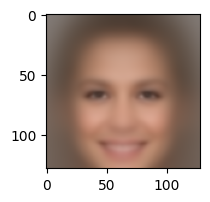

In [28]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_img_with_feat).permute(1, 2, 0))
plt.show()

### Average Non-Smiling Face

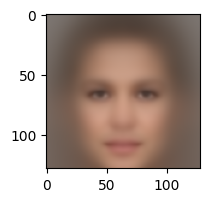

In [29]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_img_without_feat).permute(1, 2, 0))
plt.show()

### Manipulate Example Face Image

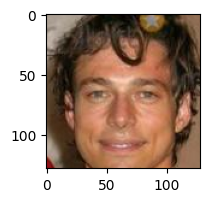

In [30]:
fig, ax = plt.subplots(figsize=(2, 2))

ax.imshow(EXAMPLE_IMAGE.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016664252..1.0473652].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0145816505..0.99743944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.033328503..1.0947305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029163301..0.9948789].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05523942..1.1420958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04374495..0.9923184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got rang

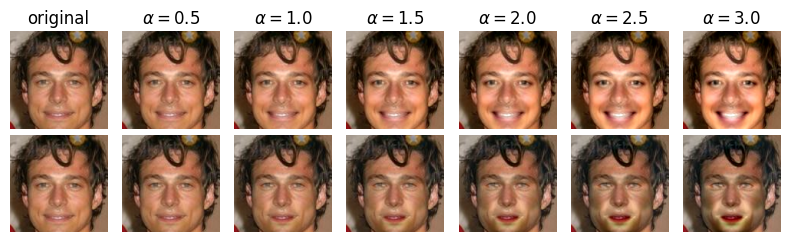

In [31]:
diff = (avg_img_with_feat - avg_img_without_feat)
plot_modified_faces(original=images[1],
                    diff=diff)

plt.tight_layout()
plt.show()

## Image Manipulation in Latent Space

In [32]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn_like(z_mu)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
    

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
    
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [33]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [34]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50,
                        save_model='vae_celeba_02.pt')

/home/shadow-monarch/Downloads/temp/helper_train.py:202: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'


Epoch: 001/003 | Batch 0000/0636 | Loss: 5466.5830
Epoch: 001/003 | Batch 0050/0636 | Loss: 2159.2722
Epoch: 001/003 | Batch 0100/0636 | Loss: 1426.9799
Epoch: 001/003 | Batch 0150/0636 | Loss: 1220.4099
Epoch: 001/003 | Batch 0200/0636 | Loss: 1067.6545
Epoch: 001/003 | Batch 0250/0636 | Loss: 1057.5643
Epoch: 001/003 | Batch 0300/0636 | Loss: 930.0585
Epoch: 001/003 | Batch 0350/0636 | Loss: 968.2476
Epoch: 001/003 | Batch 0400/0636 | Loss: 915.2282
Epoch: 001/003 | Batch 0450/0636 | Loss: 918.4606
Epoch: 001/003 | Batch 0500/0636 | Loss: 909.7373
Epoch: 001/003 | Batch 0550/0636 | Loss: 856.9408
Epoch: 001/003 | Batch 0600/0636 | Loss: 851.9998
Time elapsed: 25.75 min
Epoch: 002/003 | Batch 0000/0636 | Loss: 806.1228
Epoch: 002/003 | Batch 0050/0636 | Loss: 818.2430
Epoch: 002/003 | Batch 0100/0636 | Loss: 797.1491
Epoch: 002/003 | Batch 0150/0636 | Loss: 794.8185
Epoch: 002/003 | Batch 0200/0636 | Loss: 759.3113
Epoch: 002/003 | Batch 0250/0636 | Loss: 820.6269
Epoch: 002/003 | Bat

### Compute Average Faces in Latent Space -- More or Less Smiling

In [35]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=31, # smiling
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)

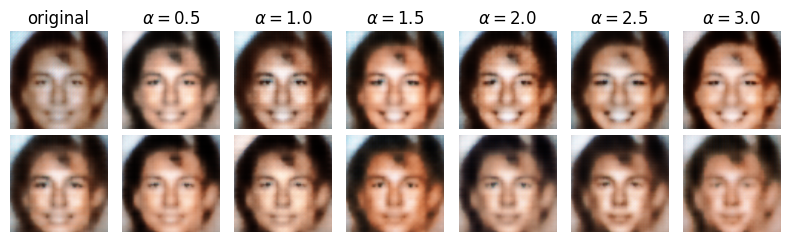

In [36]:
diff = (avg_img_with_feat - avg_img_without_feat)

example_img = EXAMPLE_IMAGE.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    encoded = model.encoding_fn(example_img).squeeze(0).to('cpu')

plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)

plt.tight_layout()
plt.show()

### Compute Average Faces in Latent Space -- With or Without Glasses

In [37]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=15, # eyeglasses
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)

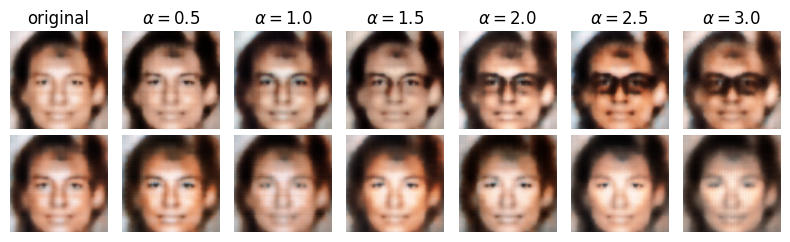

In [38]:
diff = (avg_img_with_feat - avg_img_without_feat)

example_img = EXAMPLE_IMAGE.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    encoded = model.encoding_fn(example_img).squeeze(0).to('cpu')

plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)

plt.tight_layout()
plt.show()